In [1]:
import os
import psycopg2
import pandas as pd
from dotenv import load_dotenv
import numpy as np
import plotly.graph_objects as go # for candlestick chart
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
import os

# Load environment variables from .env file
load_dotenv()

# Database configuration from environment variables
db_config = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "dbname": os.getenv("DB_NAME")
}

def read_data(table_name):
    """
    Read data from the specified PostgreSQL table and return it as a DataFrame.
    """
    try:
        # Connect to the PostgreSQL database
        conn = psycopg2.connect(**db_config)
        
        # Create a cursor object
        cursor = conn.cursor()
        
        # Execute a query to fetch data
        query = f"SELECT * FROM {table_name};"
        cursor.execute(query)
        
        # Fetch all rows from the executed query
        rows = cursor.fetchall()
        
        # Convert the data to a Pandas DataFrame
        columns = [desc[0] for desc in cursor.description]  # Get column names
        df = pd.DataFrame(rows, columns=columns)
        
        # Convert the 'date' column to datetime
        df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert to datetime
        
        return df  # Return the DataFrame
        
    except Exception as e:
        print(f"Error reading data from PostgreSQL: {e}")
        return None  # Return None in case of an error
    finally:
        if conn:
            cursor.close()
            conn.close()

# Call the function to read data from the specified table and assign it to df
df = read_data("historical_stock_data")

# Now df is defined and can be used outside the function
if df is None:
     print("No data was retrieved.")

In [2]:
data = df.sort_values(by='date').reset_index(drop=True)
display(df)

,date,open,high,low,close,adj_close,volume,stock_name
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.447412,493729600,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.458559,601904800,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.355828,552160000,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.344076,477131200,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.386254,447610800,AAPL
...,...,...,...,...,...,...,...,...
33230,2024-12-23,21566.000000,21776.750000,21476.750000,21753.250000,21753.250000,508598,NQ=F
33231,2024-12-24,21743.250000,22049.750000,21709.000000,22028.500000,22028.500000,261201,NQ=F
33232,2024-12-26,22049.500000,22111.250000,21870.250000,22008.000000,22008.000000,407116,NQ=F
33233,2024-12-27,21990.750000,22008.000000,21498.750000,21698.500000,21698.500000,572604,NQ=F


## Feature Engineering

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Group by stock identifier (replace 'stock_name' with the actual column name for stock identifiers)
data['Pct_Change'] = data.groupby('stock_name')['adj_close'].pct_change()
data['MA7'] = data.groupby('stock_name')['adj_close'].rolling(window=7).mean().reset_index(level=0, drop=True)
data['MA30'] = data.groupby('stock_name')['adj_close'].rolling(window=30).mean().reset_index(level=0, drop=True)
data['Momentum'] = data.groupby('stock_name')['adj_close'].diff(10).reset_index(level=0, drop=True)
data['MA20'] = data.groupby('stock_name')['adj_close'].rolling(window=20).mean().reset_index(level=0, drop=True)
data['BB_Upper'] = data['MA20'] + 2 * data.groupby('stock_name')['adj_close'].rolling(window=20).std().reset_index(level=0, drop=True)
data['BB_Lower'] = data['MA20'] - 2 * data.groupby('stock_name')['adj_close'].rolling(window=20).std().reset_index(level=0, drop=True)
data['EMA12'] = data.groupby('stock_name')['adj_close'].ewm(span=12, adjust=False).mean().reset_index(level=0, drop=True)
data['EMA26'] = data.groupby('stock_name')['adj_close'].ewm(span=26, adjust=False).mean().reset_index(level=0, drop=True)
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Volatility'] = data.groupby('stock_name')['adj_close'].rolling(window=10).std().reset_index(level=0, drop=True)
data['OBV'] = (data['volume'] * ((data['adj_close'] - data['adj_close'].shift(1)) > 0).astype(int) * 2 - 1).cumsum()
data['Williams_%R'] = (data.groupby('stock_name')['high'].rolling(14).max().reset_index(level=0, drop=True) - data['adj_close']) / (data.groupby('stock_name')['high'].rolling(14).max().reset_index(level=0, drop=True) - data.groupby('stock_name')['low'].rolling(14).min().reset_index(level=0, drop=True)) * -100

def rsi(df, n=14):
    delta = df['adj_close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=n).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=n).mean()
    rs = gain / loss
    rsi_value = 100 - (100 / (1 + rs))
    return rsi_value

# Calculate RSI for each stock_name
data['RSI'] = data.groupby('stock_name').apply(lambda x: rsi(x)).reset_index(level=0, drop=True)

# Boş verileri kaldır
data = data.dropna()

C:\Users\deadp\AppData\Local\Temp\ipykernel_13156\172882552.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['RSI'] = data.groupby('stock_name').apply(lambda x: rsi(x)).reset_index(level=0, drop=True)


In [4]:
data.head()

,date,open,high,low,close,adj_close,volume,stock_name,Pct_Change,MA7,...,BB_Upper,BB_Lower,EMA12,EMA26,MACD,Signal_Line,Volatility,OBV,Williams_%R,RSI
203,2010-02-16,6.003000,6.025000,5.859000,5.876500,5.876500,178654000,AMZN,-0.017800,5.906357,...,6.403278,5.668422,5.966591,6.114586,-0.147995,-3.906466,0.064472,253281694070,-79.423173,46.489023
204,2010-02-16,1781.500000,1801.500000,1775.250000,1799.250000,1799.250000,259717,NQ=F,0.008972,1762.035714,...,1870.233707,1698.616293,1774.790209,1798.053158,-23.262949,-7.777762,23.110303,253282213503,-20.090293,50.492390
205,2010-02-16,28.129999,28.370001,28.020000,28.350000,21.485996,51935600,MSFT,0.019784,21.151342,...,23.181711,20.276934,21.397630,21.865486,-0.467856,-6.315781,0.227793,253282213502,-358.893722,38.850380
206,2010-02-16,0.439500,0.443500,0.434250,0.441750,0.405122,457024000,NVDA,0.018444,0.383145,...,0.408133,0.354080,0.385403,0.389768,-0.004364,-5.053498,0.013666,253282213501,-59.270522,61.661378
207,2010-02-16,1079.130005,1095.670044,1079.130005,1094.869995,1094.869995,4080770000,^GSPC,0.018001,1072.918562,...,1138.110190,1042.358804,1082.412893,1095.493296,-13.080403,-6.658879,15.870825,261443753500,-16.370560,50.843842


In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to the 'stock_name' column
data['stock_name_encoded'] = label_encoder.fit_transform(data['stock_name'])

In [6]:
data['stock_name_encoded'].head()

203    1
204    5
205    4
206    6
207    8
Name: stock_name_encoded, dtype: int64

In [7]:
# Hedef değişkeni oluştur (Buy, Sell, Hold)
def get_signal(df):
    conditions = [
        (df['RSI'] < 30),  # Buy condition
        (df['RSI'] > 70)  # Sell condition
    ]
    choices = ['Buy', 'Sell']
    df['Signal'] = np.select(conditions, choices, default='Hold')
    return df

data = get_signal(data)

# Girdi ve hedef değişkenlerini ayıralım
X = data[['Pct_Change', 'MA7', 'MA30', 'Momentum', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal_Line', 'Volatility', 'OBV', 'Williams_%R', 'stock_name_encoded']]
y = data['Signal']

# Label Encoding (y'yi sayısal hale getirmek için)
label_encoder2 = LabelEncoder()
y = label_encoder2.fit_transform(y)

# Veriyi normalleştirme
scaler = StandardScaler()
X = scaler.fit_transform(X)

# LSTM modeline uygun hale getirmek için veriyi yeniden şekillendirelim
def reshape_for_lstm(X, y, time_steps=30):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:i + time_steps, :])
        y_lstm.append(y[i + time_steps])
    return np.array(X_lstm), np.array(y_lstm)

# 30 günlük zaman penceresi ile veriyi LSTM'e uygun hale getirelim
X_lstm, y_lstm = reshape_for_lstm(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

c:\Users\deadp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.6563 - loss: 0.8145 - val_accuracy: 0.7429 - val_loss: 0.5934
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7348 - loss: 0.6077 - val_accuracy: 0.7475 - val_loss: 0.5842
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7383 - loss: 0.5984 - val_accuracy: 0.7520 - val_loss: 0.5781
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7398 - loss: 0.5910 - val_accuracy: 0.7516 - val_loss: 0.5772
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7503 - loss: 0.5813 - val_accuracy: 0.7594 - val_loss: 0.5712
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7467 - loss: 0.5868 - val_accuracy: 0.7561 - val_loss: 0.5707
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7475 - loss: 0.5824 - val_accuracy: 0.7582 - val_loss: 0.5693
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7493 - loss: 0.5801 - 

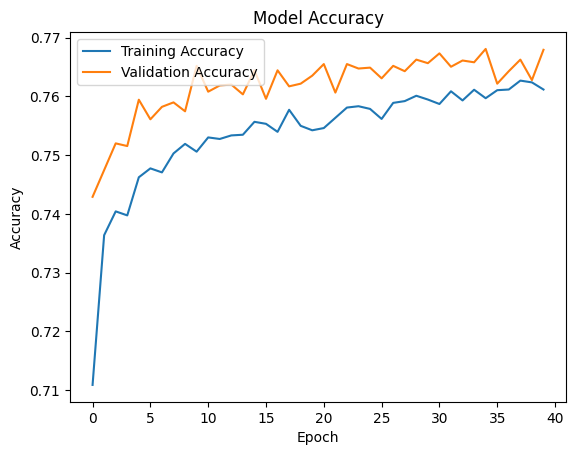

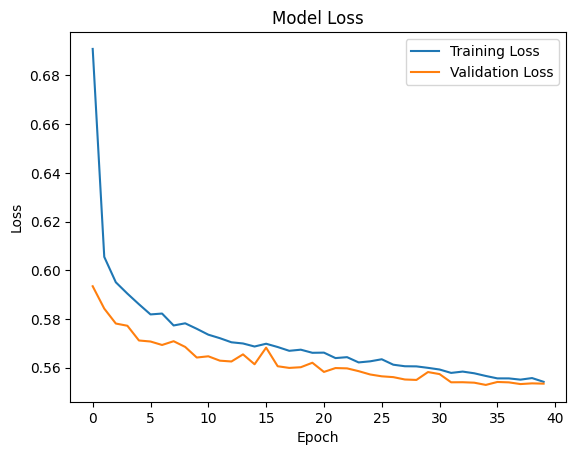

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

         Buy       0.62      0.16      0.26       446
        Hold       0.80      0.91      0.85      4792
        Sell       0.61      0.47      0.53      1351

    accuracy                           0.77      6589
   macro avg       0.68      0.51      0.55      6589
weighted avg       0.75      0.77      0.75      6589



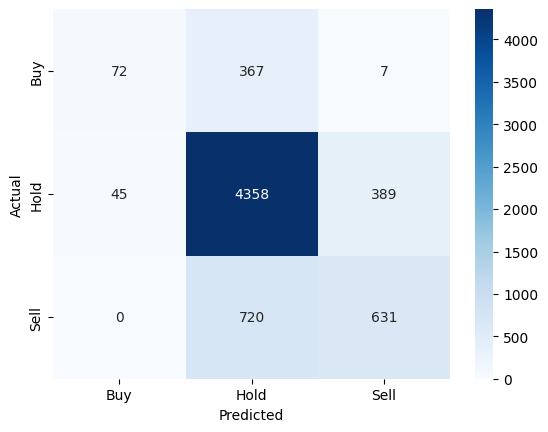

In [8]:
model = Sequential()

# İlk LSTM katmanı
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

# İkinci LSTM katmanı
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))

# Çıkış katmanı
model.add(Dense(3, activation='softmax'))  # 3 sınıf (Buy, Sell, Hold)

from tensorflow.keras.optimizers import Adam

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)  # Adjust the learning rate as needed
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

# Initialize EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modeli eğitme with EarlyStopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Performansı değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğu grafiği
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Eğitim ve doğrulama kaybı grafiği
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Test verisi üzerindeki tahminler
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek ve tahmin edilen sınıfları karşılaştıralım
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_classes, target_names=label_encoder2.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder2.classes_, yticklabels=label_encoder2.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [9]:
data[data['RSI'] < 30]

,date,open,high,low,close,adj_close,volume,stock_name,Pct_Change,MA7,...,EMA12,EMA26,MACD,Signal_Line,Volatility,OBV,Williams_%R,RSI,stock_name_encoded,Signal
579,2010-05-03,0.394750,0.397000,0.382500,0.388500,0.356288,1078972000,NVDA,-0.010822,0.370863,...,0.375986,0.384183,-0.008197,4.015825,0.010676,759521609934,-137.049448,26.125979,6,Buy
584,2010-05-04,0.382500,0.383250,0.363250,0.368750,0.338175,1311376000,NVDA,-0.050836,0.365327,...,0.370169,0.380775,-0.010606,3.937041,0.014358,773620764573,-127.938533,18.762480,6,Buy
592,2010-05-05,0.361250,0.371750,0.358000,0.362500,0.332443,1330840000,NVDA,-0.016949,0.358449,...,0.364365,0.377195,-0.012830,1.208254,0.017929,788969202565,-133.738120,15.789434,6,Buy
596,2010-05-06,0.360000,0.367500,0.326000,0.355000,0.325565,1002888000,NVDA,-0.020690,0.352128,...,0.358396,0.373371,-0.014975,1.812557,0.020598,790736212745,-100.410147,18.080329,6,Buy
601,2010-05-06,1.957000,1.958000,1.855000,1.920000,1.364735,9155000,AVGO,-0.019908,1.450844,...,1.460331,1.465061,-0.004730,0.297006,0.060882,812230531070,-213.225098,28.662339,2,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32889,2024-11-04,220.990005,222.789993,219.710007,222.009995,221.766006,44944500,AAPL,-0.004038,228.236036,...,228.253372,228.498253,-0.244881,13.802816,4.613120,27411143950094,-88.004668,28.425623,0,Buy
33032,2024-11-26,164.600006,166.369995,162.690002,164.740005,164.299789,16308800,AVGO,-0.000485,164.131664,...,167.023445,169.837697,-2.814252,7.641413,3.263579,27527784707025,-84.867960,23.675815,2,Buy
33045,2024-11-27,163.199997,163.199997,157.539993,159.669998,159.243332,19722700,AVGO,-0.030776,163.276812,...,165.826504,169.052929,-3.226424,22.402475,2.614743,27527961341772,-93.808295,8.293062,2,Buy
33051,2024-11-29,159.570007,162.690002,159.080002,162.080002,161.646896,11024000,AVGO,0.015094,162.810917,...,165.183488,168.504334,-3.320846,8.059449,1.802332,27528025387566,-84.258715,15.426599,2,Buy
